<a href="https://colab.research.google.com/github/frzkhtr/End2End_forecasting_solutions/blob/main/Copy_of_End_2_end_forecasting_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api
#from statsmodels.tsa.Sarima_model import SARIMA
#from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
#from nsepy import get_history
from datetime import date, timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import holidays
%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.simplefilter("ignore")
from math import sqrt
from math import exp
from numpy import log
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 

In [ ]:
def pipeline(data):
  print('Ingesting Data....')

  horizon_dates = horizon(data, forecast_horizon, freq, series_type)

  print(f'Total datapoints: {data.shape[0]}')

  data.interpolate(method = 'time', inplace = True) #fill missing values


  print('Checking for missing Dates....')
  if missing_dates(data) > 0:
    print(f'{round(missing_dates(data), 2)}% of dates are missing from dataset!')
    print('Imputing Data....')
    #imputing the missing date and its values
    data_imputed = missing_values(data,columns)
    print('Imputation Done. New Dataframe formed...')
  else: 
    print('No missing date!!!')
    data_imputed = data.copy()
  
#roll up the data if possible. 
  if series_type != rollup_level:
    print('Checking Rollup...')
    data_imputed = if_roll_up_possible(data_imputed, series_type, rollup_level)


  #checking stationarity of data
  #return stationarity = True/False, columns which are not stationarity, parameter d, log_transform = True/False
  stationarity, non_stationary_columns, d, log_transform = stationarity_check(data_imputed, columns)

  #check for seasonality
  #return seasonality = True/False and order of seasonality(m)
  seasonality, seasonal_order = check_seasonality(data, columns)
  trend = False


  baseline_model_prediction = forecast_baseline(data_imputed[columns[0]], d[0], horizon_dates)
  print(pd.DataFrame({
      'Date': horizon_dates,
      columns[0] : baseline_model_prediction
      }))
  models = check_models(data_imputed, columns, trend, seasonality, exo, horizon_dates, d, seasonal_order, log_transform)
  predicted = models
  print(pd.DataFrame({
      'Date': horizon_dates,
      columns[0] : predicted
      }))


In [ ]:
#return the dates for the given horizon

def horizon(data, forecast_horizon, freq, series_type):  #Input: Data, number of forecast, frequency of date, frequency of series
  a =  max(data.index)
  if series_type == 0:
    b = timedelta(days = 1)
    #a = a + b
    dates = []
    x = 0
    while x < forecast_horizon:
      a = a + b
      dates.append(a.to_pydatetime())
      x += 1



  if series_type == 1:
    b = timedelta(weeks = 1)
    #a = a + b
    dates = []
    x = 0
    while x < forecast_horizon:
      a = a + b
      dates.append(a.to_pydatetime())
      x += 1


  if series_type == 2:
    b = timedelta(days = 30 )
    #a = a + b
    dates = []
    x = 0
    while x < forecast_horizon:
      a = a + b
      dates.append(a.to_pydatetime())
      x += 1


  if series_type == 3:
    b = timedelta(weeks = 13)
    #a = a + b
    dates = []
    x = 0
    while x < forecast_horizon:
      a = a + b
      dates.append(a.to_pydatetime())
      x += 1

  return dates

In [ ]:
def missing_values(data,columns):
    df1 = pd.DataFrame(pd.date_range(data.index[0],data.index[-1]-timedelta(days=1),freq='d'), columns = [index])
    df = data.reset_index()[[index] + columns]
    df1 = df1.merge(df, on = index, how = 'left').copy()
    #new_col = columns[0] + '_imputed'
    
    df1.set_index(index, inplace = True, drop = True)
    for col in columns:
      df1 = interpolate_miss(df1, col)
    return df1

In [ ]:
def interpolate_miss(data, col):
    #new_col = col + '_imputed'
    data[col] = data[col].interpolate(method = 'time')
    return data

In [ ]:
def missing_dates(data):
    if (data.index[1] - data.index[0]).days == 1:
      should_be = (data.index[-1] - data.index[0]).days
      total = data.shape[0]
      return ((should_be - total)/total)*100

    elif (data.index[1] - data.index[0]).days == 7:
      should_be = ((data.index[-1] - data.index[0]).days) / 7
      total = data.shape[0]
      return ((should_be - total)/total)*100

    elif (data.index[1] - data.index[0]).days in [28, 29, 30 ,31] :
      should_be = ((data.index[-1] - data.index[0]).days) / 30
      total = data.shape[0]
      return ((should_be - total)/total)*100

    elif (data.index[1] - data.index[0]).days > 360:
      should_be = ((data.index[-1] - data.index[0]).days) / 365
      total = data.shape[0]
      return ((should_be - total)/total)*100

In [ ]:
def if_roll_up_possible(data, series, rollup_level):
    if series > rollup_level:
        a = series
        print(f'Roll up not possible. Please enter from these: {level[a:]}')
    else:
        dg = data.groupby(pd.Grouper(freq= frequency[rollup_level])).sum()
        if dg.shape[0] < 50:
            print(f'Data not sufficient')
        else:
          print(f'Rollup done. Total datapoints after Rollup: {dg.shape[0]}')
          return dg
        

In [ ]:
def d_value(series):
  i = 1
  adi = 1
  while (adi > 0.05) & (i < 5):
    series = series.diff().dropna()
    adi = adfuller(series)[1]
    i += 1
  return i

In [ ]:
def stationarity_check(data, columns):
  print('Checking Stationarity of data...')
  dvalue = []
  non_stationary_columns = []
  stationary = True
  for col in columns:
    log_transform = False
    s = data[col]
    ad = adfuller(s)
    if ad[1] < 0.05:
      print(f'{col} data is stationary')
      dvalue.append(0)
    else:
      non_stationary_columns.append(col)
      print(f'{col} data is not stationary...')
      print('checking for d value...')
      ds = d_value(s)
      if ds > 2:
        print('Transforming into log data')
        s = log(s)
        log_transform = True
        ds = d_value(s)
      dvalue.append(ds)

      stationary = False
  if stationary == True:
    print('Overall data is Stationary')
  else:
    print('Overall data is not Stationary')
  return stationary, non_stationary_columns, dvalue, log_transform

In [ ]:
def check_seasonality(data, columns):
  s = data[columns[0]]
  decomposition = seasonal_decompose(s, extrapolate_trend = 'freq',  model = 'additive')
  seasonal = decomposition.seasonal
  seasonal = seasonal.to_frame()
  mean = seasonal.iloc[2,0]
  std = seasonal.iloc[3, 0]
  done = False
  check = 0
  i = 1
  while done == False:
    if (seasonal.iloc[i, 0] - 10) <= seasonal.iloc[0,0] <= (seasonal.iloc[i, 0] + 10):
      check = 0
      for j in range(10):
        if (seasonal.iloc[i + j, 0] - 10) <= seasonal.iloc[j,0] <= (seasonal.iloc[i + j, 0] + 10):
          check += 1
          if check >= 5:
            done = True
            seasonality = True
          print (i)
    i += 1

  else:
    seasonality = False
  #check Seasonality
  return seasonality, i

In [ ]:
def forecast_baseline(series, d, horizon):
  X = series.values
  X = [float(x) for x in X]
  size = int(len(X) * 0.7)
  train, test = X[0:size], X[size:len(X)]
  history = [x for x in train]
  predictions = list()
  # walk-forward validation
  for t in range(len(test)):
	  model = ARIMA(history, order=(0,d,0))
	  model_fit = model.fit()
	  output = model_fit.forecast()
	  yhat = output[0]
	  predictions.append(yhat)
	  obs = test[t]
	  history.append(obs)
	  #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
  rmse = sqrt(mean_squared_error(test, predictions))
  print('Test RMSE: %.3f' % rmse)
  #plot forecasts against actual outcomes
  plt.plot(test)
  plt.plot(predictions, color='red')
  plt.show()


  X = series.values
  X = [float(x) for x in X]
  #size = int(len(X) * 0.7)
  #train, test = X[0:size], X[size:len(X)]
  history = [x for x in X]
  predictions = list()
  # walk-forward validation
  for t in range(len(horizon)):
	  model = ARIMA(history, order=(0,d,0))
	  model_fit = model.fit()
	  output = model_fit.forecast()
	  yhat = output[0]
	  predictions.append(yhat)
	  #obs = test[t]
	  history.append(yhat)
  return [x[0] for x in predictions] 

In [ ]:
def check_models(data, columns, trend, seasonality, exo, horizon_dates, d_value, seasonal_order, log_transform):
  if len(columns) == 1:                       #univariate
    if trend == False:
      if seasonality == False:
        if  exo == None:
          models = forecast_arima(data[columns[0]], d_value[0], horizon_dates, log_transform)
        else:
          models = forecast_arimax(data[columns[0]], exo, d_value[0], horizon_dates, log_transform)
      else:
        if exo == None:
          models = forecast_Sarima(data[columns[0]], d_value[0], horizon_dates, seasonal_order,log_transform)
        else:
          models = forecast_Sarimax(data[columns[0]], exo, d_value[0], horizon_dates, log_transform)
    else:
      if seasonality == False:
        if  exo == None:
          models = forecast_arima(data[columns[0]], d_value[0], horizon_dates, log_transform)
        else:
          models = forecast_arimax(data[columns[0]], exo, d_value[0], horizon_dates, 'log_transform')
      else:
        if exo == None:
          models = forecast_Sarima(data[columns[0]], d_value[0], horizon_dates, seasonal_order,log_transform)
        else:
          models = forecast_Sarimax(data[columns[0]], exo, d_value[0], horizon_dates)
  else:
    if trend == False:
      if seasonality == False:
        if  exo == None:
          models = lstm(data, 4)
        else:
          models = lstm(data, 4)
      else:
        if exo == None:
          models = lstm(data, 4)
        else:
          models = lstm(data, 4)
    else:
      if seasonality == False:
        if  exo == None:
          models = lstm(data, 4)
        else:
          models = lstm(data, 4)
      else:
        if exo == None:
          models = lstm(data, 4)
        else:
          models = lstm(data, 4)
  return models

In [ ]:
def forecast_arima(series, d, horizon, log_transform):
	original_series = series.copy()
	series_diff = series.copy()
	diff = 0

	if log_transform:
		series_diff = log(series_diff)
	
	print(f'D: {d}')
	while diff < d:
		series_diff = series_diff.diff().dropna()
		diff += 1
	acf_values = acf(series_diff.values)
	pacf_values = pacf(series_diff.values)
	n = series_diff.shape[0]
	crit_value = (exp(2*1.96/sqrt(n - 3)-1))/(exp(2*1.96/sqrt(n-3)+1))
	qs = []
	ps = []
	i = 1
	while i < 5:
		if (acf_values[1] > crit_value) or (acf_values[1] < -crit_value):
			qs.append(i)
		i += 1
	for j in range(1, len(qs)):
		if (pacf_values[j] > crit_value) or (acf_values[1] < -crit_value):
			ps.append(j)
	print(qs, ps)
	rmse = float('inf')
	order_best = (0, d, 0)



	if log_transform:
		series = log(series)


	for q in qs:
		for p in ps:
			order_temp = (p, d, q)
			print(order_temp)
			#val = series.values
			X = series.values
			size = int(len(X) * 0.7)
			train, test = X[0:size], X[size:len(X)]
			history = [x for x in train]
			predictions = list()
			try:
				for t in range(len(test)):
					model = ARIMA(history, order=order_temp)
					model_fit = model.fit(transparams = True)
					output = model_fit.forecast()
					yhat = output[0]
					predictions.append(yhat)
					obs = test[t]
					history.append(obs)
	  		#print('predicted=%f, expected=%f' % (yhat, obs))
		# evaluate forecasts
				rmse_temp = sqrt(mean_squared_error(test, predictions))
				print(rmse_temp)
				if rmse_temp < rmse:
					rmse = rmse_temp
					order_best = order_temp
					best = predictions

			except:
				pass


	if rmse == float('inf'):
		print('Baseline model shows best forecast')
		best = forecast_baseline(original_series, d, horizon)
	
	else:
		val = series.values
		history = [x for x in val]
		predictions = list()
		for t in range(len(horizon)):
			model = ARIMA(history, order=order_best)
			model_fit = model.fit(transparams = False)
			output = model_fit.forecast()
			yhat = output[0]
			predictions.append(yhat)
			#obs = test[t]
			history.append(yhat)
	  	#print('predicted=%f, expected=%f' % (yhat, obs))


			print(f'Total RMSE: {rmse}')
			plt.plot(test)
			plt.plot(best, color='red')
			plt.show()
			print(f'best order for ARIMA model: {order_best}')
 

	if log_transform:
		forecasted_data = [exp(x[0]) for x in predictions]

	else:
		forecasted_data = [x[0] for x in predictions]


	return forecasted_data

In [ ]:
def forecast_arimax(series, exo, d, horizon, log_transform):
	original_series = series.copy()
	series_diff = series.copy()
	diff = 0

	if log_transform:
		series_diff = log(series_diff)
	
	print(f'D: {d}')
	while diff < d:
		series_diff = series_diff.diff().dropna()
		diff += 1
	acf_values = acf(series_diff.values)
	pacf_values = pacf(series_diff.values)
	n = series_diff.shape[0]
	crit_value = (exp(2*1.96/sqrt(n - 3)-1))/(exp(2*1.96/sqrt(n-3)+1))
	qs = []
	ps = []
	i = 1
	while i < 5:
		if (acf_values[1] > crit_value) or (acf_values[1] < -crit_value):
			qs.append(i)
		i += 1
	for j in range(1, len(qs)):
		if (pacf_values[j] > crit_value) or (acf_values[1] < -crit_value):
			ps.append(j)
	print(qs, ps)
	rmse = float('inf')
	order_best = (0, d, 0)



	if log_transform:
		series = log(series)


	for q in qs:
		for p in ps:
			order_temp = (p, d, q)
			print(order_temp)
			#val = series.values
			X = series.values
			size = int(len(X) * 0.7)
			train, test = X[0:size], X[size:len(X)]
			history = [x for x in train]
			predictions = list()
			try:
				for t in range(len(test)):
          #model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = (0,0,0,0) exog = exo)
					model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = (0,0,0,0), exog = exo)
					model_fit = model.fit(transparams = True)
					output = model_fit.forecast()
					yhat = output[0]
					predictions.append(yhat)
					obs = test[t]
					history.append(obs)
	  		#print('predicted=%f, expected=%f' % (yhat, obs))
		# evaluate forecasts
				rmse_temp = sqrt(mean_squared_error(test, predictions))
				print(rmse_temp)
				if rmse_temp < rmse:
					rmse = rmse_temp
					order_best = order_temp
					best = predictions

			except:
				pass


	if rmse == float('inf'):
		print('Baseline model shows best forecast')
		best = forecast_baseline(original_series, d, horizon)
	
	else:
		val = series.values
		history = [x for x in val]
		predictions = list()
		for t in range(len(horizon)):
			model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = (0,0,0,0), exog = exo)
			model_fit = model.fit(transparams = False)
			output = model_fit.forecast()
			yhat = output[0]
			predictions.append(yhat)
			#obs = test[t]
			history.append(yhat)
	  	#print('predicted=%f, expected=%f' % (yhat, obs))


			print(f'Total RMSE: {rmse}')
			plt.plot(test)
			plt.plot(best, color='red')
			plt.show()
			print(f'best order for ARIMA model: {order_best}')
 

	if log_transform:
		forecasted_data = [exp(x[0]) for x in predictions]

	else:
		forecasted_data = [x[0] for x in predictions]


	return forecasted_data

In [ ]:
def forecast_Sarima(series, d, horizon, m,log_transform):
  original_series = series.copy()
  series_diff = series.copy()
  diff = 0

  if log_transform:
	  series_diff = log(series_diff)
	
  print(f'D: {d}')
  while diff < d:
    series_diff = series_diff.diff().dropna()
    diff += 1
  acf_values = acf(series_diff.values)
  pacf_values = pacf(series_diff.values)
  n = series_diff.shape[0]
  crit_value = (exp(2*1.96/sqrt(n - 3)-1))/(exp(2*1.96/sqrt(n-3)+1))
  qs = []
  ps = []
  i = 1
  while i < 5:
    if (acf_values[1] > crit_value) or (acf_values[1] < -crit_value):
      qs.append(i)
    i += 1
  for j in range(1, len(qs)):
    if (pacf_values[j] > crit_value) or (acf_values[1] < -crit_value):
      ps.append(j)
  print(qs, ps)
  rmse = float('inf')
  order_best = (0, d, 0)



  if log_transform:
	  series = log(series)


  for q in qs:
    for p in ps:
      order_temp = (p, d, q)
      seasonal_order_temp = (p, d, q, m)
      print(order_temp)
			#val = series.values
      X = series.values
      size = int(len(X) * 0.7)
      train, test = X[0:size], X[size:len(X)]
      history = [x for x in train]
      predictions = list()
      try:
        for t in range(len(test)):
          #model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = (0,0,0,0) exog = exo)
          model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = seasonal_order_temp, exog = exo)
          model_fit = model.fit(transparams = True)
          output = model_fit.forecast()
          yhat = output[0]
          predictions.append(yhat)
          obs = test[t]
          history.append(obs)
		# evaluate forecasts
        rmse_temp = sqrt(mean_squared_error(test, predictions))
        print(rmse_temp)
        if rmse_temp < rmse:
          rmse = rmse_temp
          order_best = order_temp
          best = predictions

      except:
        pass


  if rmse == float('inf'):
    print('Baseline model shows best forecast')
    best = forecast_baseline(original_series, d, horizon)
	
  else:
    val = series.values
    history = [x for x in val]
    predictions = list()
    for t in range(len(horizon)):
      model = sm.tsa.statespace.SARIMAX(history, order - order_temp, seasonal_order = (0,0,0,0), exog = exo)
      model_fit = model.fit(transparams = False)
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      history.append(yhat)
	  	

      print(f'Total RMSE: {rmse}')
      plt.plot(test)
      plt.plot(best, color='red')
      plt.show()
      print(f'best order for ARIMA model: {order_best}')
 

  if log_transform:
    forecasted_data = [exp(x[0]) for x in predictions]

  else:
    forecasted_data = [x[0] for x in predictions]


  return forecasted_data

In [ ]:
def lstm(data, forecast_horizon):
  n_rows = data.shape[0]
  N_features = data.shape[1]
  b = int(n_rows / 5)
  n = int(n_rows / 10)
  scaler = MinMaxScaler()
  data_scaled = scaler.fit_transform(data)
  features = data_scaled
  target = data_scaled[:,0]
  #TimeseriesGenerator(features, target, length = n, sampling_rate = 1 , batch_size = b)[]
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, shuffle = False)
  train_generator = TimeseriesGenerator(x_train, y_train, length = n, sampling_rate = 1 , batch_size = b)
  test_generator = TimeseriesGenerator(x_test, y_test, length = n, sampling_rate = 1 , batch_size = b)


  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(128, input_shape = (n, N_features), return_sequences = True))
  model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
  model.add(tf.keras.layers.LSTM(128, return_sequences = True))
  model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.LSTM(64, return_sequences = False))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(1))

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')


  model.compile(loss = tf.losses.MeanAbsoluteError(),
              optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])


  history = model.fit_generator(train_generator, epochs= 100, validation_data= test_generator,
                              shuffle = False, callbacks = [early_stopping])
  
  predictions = model.predict_generator(test_generator)
  df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(y_test[n:])], axis = 1)
  #rev = scaler.inverse_transform(df_pred)
  columns =  ['predicted', 'actual']
  df_pred.columns = columns
  #df_pred['predicted'] = rev[:,0]
  #df_pred['actual'] = rev[:,1]

  df_pred.plot()

  return df_pred


In [ ]:

#Defining Input Choice

dimensions = ['Univariate', 'Multivariate']      #Dimension of data
level = ['daily', 'weekly', 'monthly', 'quartely', 'yearly']     #time level of data
holidays = ['Weekend', 'Weekday', 'National_holidays', 'Others']  #any holidays to be considered
business_in_holidays = [True, False]    #Does business occur in holiday
columns = []                            #if univariate, defining column
rollup_aggregation = ['Count', 'Average' ]
frequency = ['1D', '7D', '1M', '3M', '12M']
forecast_horizon = None

In [ ]:
#Input

dimension = 'Univariate'
series_type = 0
rollup_level = 1
rollup_aggregation = 'Count'
columns = ['Power']
index = 'Date'
forecast_horizon = 10
freq = None
exo = None

timeseries_data = '/content/drive/MyDrive/Time Series Forecast/Demo_data.xlsx'



data = pd.read_excel(timeseries_data, index_col=index,parse_dates=True)
data.drop(data.index[0], inplace = True)

In [ ]:
pipeline(data)

Ingesting Data....
Total datapoints: 709
Checking for missing Dates....
2.54% of dates are missing from dataset!
Imputing Data....
Imputation Done. New Dataframe formed...
Checking Rollup...
Rollup done. Total datapoints after Rollup: 104
Checking Stationarity of data...
Power data is stationary
Overall data is Stationary


ValueError: ignored

In [ ]:
'''Data Cite : Zhang, Yong; Zhong, Miner; Geng, Nana; Jiang, Yunjian (2017): Forecasting electric vehicles sales with univariate and multivariate time series models: The case of China. PLOS ONE. Dataset. https://doi.org/10.1371/journal.pone.0176729 '''

In [ ]:
#Input

dimension = 'Univariate'
series_type = 2
rollup_level = 2
rollup_aggregation = None
columns = ['BEV sales']
index = 'Year/Month'
forecast_horizon = 4
freq = None

exo_data = data = pd.read_csv('/content/drive/MyDrive/Time Series Forecast/Exo_for_sales_data.csv', index_col=index ,parse_dates=True)
exo = [x[0] for x in exo_data]

timeseries_data = '/content/drive/MyDrive/Time Series Forecast/Sales_Data.csv'

data = pd.read_csv(timeseries_data, index_col=index ,parse_dates=True)
data[columns[0]] = data[columns[0]].apply(lambda x: float(x))

Ingesting Data....
Total datapoints: 60
Checking for missing Dates....
No missing date!!!
Checking Stationarity of data...
BEV sales data is not stationary...
checking for d value...
Transforming into log data
Overall data is not Stationary
12
12
12
12
12
12
12
12
12
12
Test RMSE: 12394.978


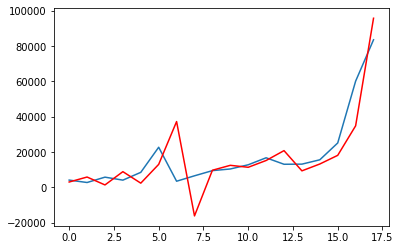

        Date      BEV sales
0 2015-12-31  107322.948276
1 2016-01-30  131558.844828
2 2016-02-29  156207.689655
3 2016-03-30  181269.482759
D: 2
[1, 2, 3, 4] [1, 2, 3]
(1, 2, 1)
(2, 2, 1)
(3, 2, 1)
(1, 2, 2)
(2, 2, 2)
(3, 2, 2)
(1, 2, 3)
(2, 2, 3)
(3, 2, 3)
(1, 2, 4)
(2, 2, 4)
(3, 2, 4)
Baseline model shows best forecast
Test RMSE: 12394.978


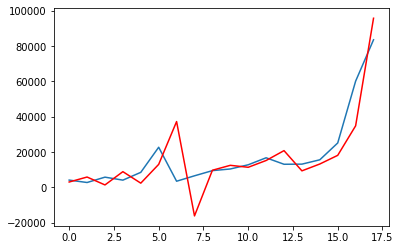

ValueError: ignored

In [ ]:
pipeline(data)

In [ ]:
#Input

dimension = 'Multuvariate'
series_type = 2
rollup_level = 2
rollup_aggregation = None
#holiday = ['Weekend', 'National_holidays']
#other = [False]
#business = False
columns = ['BEV sales', 'PHEV sales']
index = 'Year/Month'
forecast_horizon = 4
freq = None

exo_data = data = pd.read_csv('/content/drive/MyDrive/Time Series Forecast/Exo_for_sales_data.csv', index_col=index ,parse_dates=True)
exo = None

timeseries_data = '/content/drive/MyDrive/Time Series Forecast/Sales_Data.csv'

data = pd.read_csv(timeseries_data, index_col= index ,parse_dates=True)
#data.drop(data.index[0], inplace = True)
#data[columns[0]] = data[columns[0]].apply(lambda x: float(x))

In [ ]:
#data = pd.read_csv(timeseries_data)
data.head()

,BEV sales,PHEV sales
Year/Month,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


Ingesting Data....
Total datapoints: 60
Checking for missing Dates....
No missing date!!!
Checking Stationarity of data...
BEV sales data is not stationary...
checking for d value...
Transforming into log data
PHEV sales data is not stationary...
checking for d value...
Transforming into log data
Overall data is not Stationary
12
12
12
12
12
12
12
12
12
12
Test RMSE: 12394.978


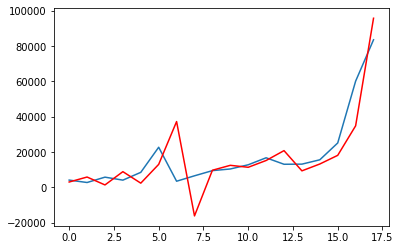

        Date      BEV sales
0 2015-12-31  107322.948276
1 2016-01-30  131558.844828
2 2016-02-29  156207.689655
3 2016-03-30  181269.482759
Epoch 1/100
4/4 [==============================] - 7s 417ms/step - loss: 0.0189 - mean_absolute_error: 0.0189 - val_loss: 0.3795 - val_mean_absolute_error: 0.3795
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0243 - mean_absolute_error: 0.0243 - val_loss: 0.3834 - val_mean_absolute_error: 0.3834
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0231 - mean_absolute_error: 0.0231 - val_loss: 0.3871 - val_mean_absolute_error: 0.3871
Epoch 4/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0195 - mean_absolute_error: 0.0195 - val_loss: 0.3767 - val_mean_absolute_error: 0.3767
Epoch 5/100
4/4 [==============================] - 0s 32ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.3657 - val_mean_absolute_error: 0.3657
Epoch 6/100
4/4 [==============================] 

ValueError: ignored

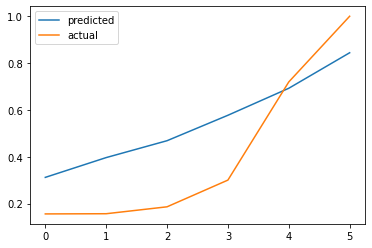

In [ ]:
pipeline(data)

In [ ]:
df.head()

,Power,Lights,Appliances
Date,,,
2017-01-02,6470.376667,610.0,12340.0
2017-01-03,6295.808333,780.0,13970.0
2017-01-04,6249.562500,720.0,21800.0
2017-01-05,NaN,860.0,18050.0
2017-01-06,6051.949167,1150.0,18040.0


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Time Series Forecast/Demo_data.xlsx', index_col="Date",parse_dates=True)
df.interpolate(method = 'time', inplace = True)
df.sort_index(inplace=True)
df.shape

(710, 3)

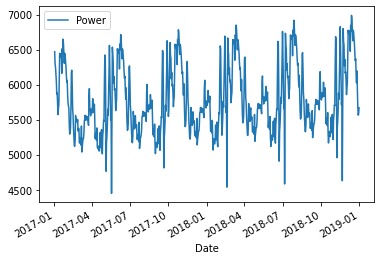

In [ ]:
s = df['Power'].to_frame()
#s.sort_index(inplace=True)
s.plot()

In [ ]:
#s.reset_index(inplace = True)
s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 710 entries, 2017-01-02 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Power   710 non-null    float64
dtypes: float64(1)
memory usage: 31.1 KB


In [ ]:
decomposition = seasonal_decompose(s.asfreq('s'), model = 'additive')
seasonal = decomposition.seasonal.to_frame()
seasonal.plot()

ValueError: ignored

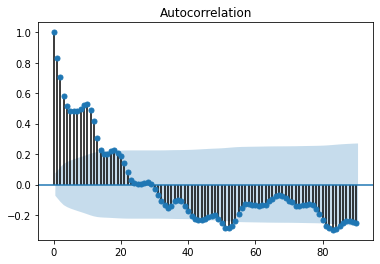

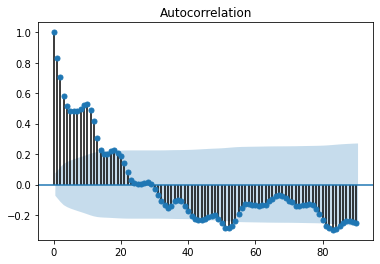

In [ ]:
plot_acf(s, lags = 90)

In [ ]:
df.head()

,Power,Lights,Appliances
Date,,,
2017-01-02,6470.376667,610.0,12340.0
2017-01-03,6295.808333,780.0,13970.0
2017-01-04,6249.562500,720.0,21800.0
2017-01-05,6150.755833,860.0,18050.0
2017-01-06,6051.949167,1150.0,18040.0


In [ ]:
s

Date
2017-01-02    6470.376667
2017-01-03    6295.808333
2017-01-04    6249.562500
2017-01-05    6150.755833
2017-01-06    6051.949167
                 ...     
2018-12-27    5944.443652
2018-12-28    5697.503586
2018-12-29    5564.862351
2018-12-30    5580.795238
2018-12-31    5670.456705
Name: Power, Length: 710, dtype: float64

In [ ]:
df.interpolate(method = 'time', inplace = True)
s = df['Power']
df.interpolate(method = 'time', inplace = True)
decomposition = seasonal_decompose(s, model = 'additive')

ValueError: ignored

In [ ]:
seasonal = decomposition.seasonal.to_frame()
seasonal.describe().iloc[1,0]

-373.3523822528388

In [ ]:
list(range(-10, 0))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

In [ ]:
int(seasonal.iloc[2, 0]) - 10

-7650

In [ ]:
done = False
check = 0
i = 1
while done == False:
  if (seasonal.iloc[i, 0] - 10) <= seasonal.iloc[0,0] <= (seasonal.iloc[i, 0] + 10):
    check = 0
    for j in range(10):
      if (seasonal.iloc[i + j, 0] - 10) <= seasonal.iloc[j,0] <= (seasonal.iloc[i + j, 0] + 10):
        check += 1
        if check >= 5:
          done = True
        print (i)
  i += 1

12
12
12
12
12
12
12
12
12
12


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time Series Forecast/Demo_data.csv', index_col="Date",parse_dates=True)
n = df.shape[0]
N_features = df.shape[1]
b = int((n * 0.2) / 5)
horizon = 30
n = horizon + 5
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
features = df
target = df[:,0]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, shuffle = False)
train_generator = TimeseriesGenerator(x_train, y_train, length = n, sampling_rate = 1 , batch_size = b)
test_generator = TimeseriesGenerator(x_test, y_test, length = n, sampling_rate = 1 , batch_size = b)

In [ ]:
from keras.layers import Input
input = Input(n, N_features)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (n, N_features), return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min')

model.compile(loss = tf.losses.MeanAbsoluteError(),
              optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])


history = model.fit_generator(train_generator, epochs= 100, validation_data= test_generator,
                              shuffle = False, callbacks = [early_stopping])





In [ ]:
model.evaluate_generator(test_generator)

In [ ]:
predictions = model.predict_generator(test_generator)

In [ ]:
model.

In [ ]:
test_generator[3]

In [ ]:
y_test

In [ ]:
 plt.figure(figsize=(16,9))
 plt.plot(history.history['loss'])
 plt.plot(history.history['val_loss'])
 plt.title('Model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train loss', 'validation loss'])
 plt.show() 

In [ ]:
predictions

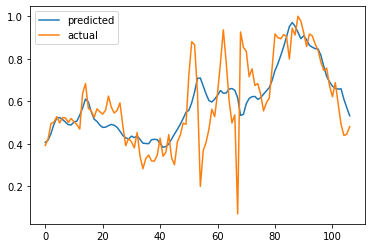

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(y_test[n:])], axis = 1)
columns =  ['predicted', 'actual']
df_pred.columns = columns
df_pred.plot()

In [ ]:
df_pred

,predicted,actual
0,0.026019,0.199765
1,0.029414,0.155836
2,0.031004,0.156663
3,0.034682,0.186177
4,0.038437,0.300289
5,0.042401,0.719483
6,0.046723,1.000000


In [ ]:
x_test.shape

(142, 3)

In [ ]:
data.rolling(5)

Rolling [window=5,center=False,axis=0]

In [ ]:
(exp(2*1.96/sqrt(59 - 3)-1))/(exp(2*1.96/sqrt(59-3)+1))

0.1353352832366127

In [ ]:
acf(log(s).diff().dropna().values)

array([ 1.        , -0.36905067, -0.07343527, -0.0811164 ,  0.00968057,
        0.07406532, -0.07909408,  0.17862722, -0.19549884,  0.14443138,
       -0.32162827,  0.2127612 ,  0.22648015, -0.17806277, -0.00609883,
       -0.00947955, -0.01098472,  0.04531976,  0.08333116, -0.10634425,
       -0.016505  ,  0.0870694 , -0.19963613,  0.01298266,  0.21406771,
       -0.0665476 ,  0.02198595, -0.06451302, -0.02141105,  0.09208105,
       -0.05320085,  0.01058642,  0.03699672,  0.02305001, -0.27001534,
        0.14650039,  0.10881492, -0.07097137,  0.07376892, -0.11094907,
        0.09482839])

In [ ]:
(exp(2*1.96/sqrt(104 - 3)-1))/(exp(2*1.96/sqrt(104-3)+1))

0.13533528323661267

In [ ]:
(exp(2*1.96/sqrt(104-3)-1))/(exp(2*1.96/sqrt(104-3)+1))

0.13533528323661267

In [ ]:
columns

['Power']

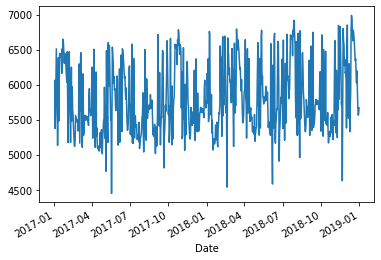

In [ ]:
s = df['Power']
s.plot()

In [ ]:
decomposition = seasonal_decompose(s, freq = 1, model = 'multiplicative')

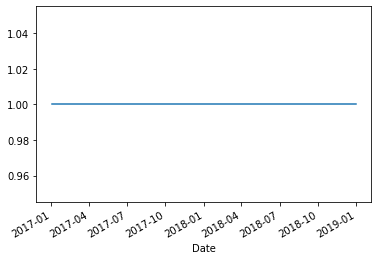

In [ ]:
decomposition.seasonal.plot()

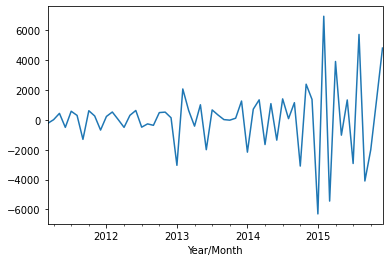

In [ ]:
s.diff().dropna().diff().dropna().plot()

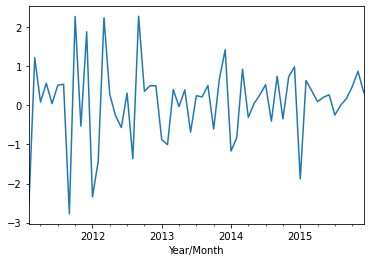

In [ ]:
from numpy import log
log(s).diff().dropna().plot()

In [ ]:
adfuller(s.diff().dropna().diff().dropna())[1]

0.0002745871164326168

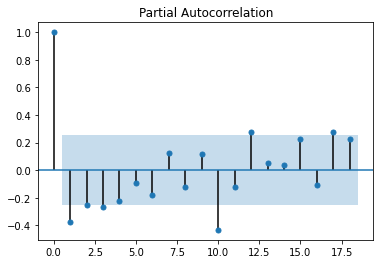

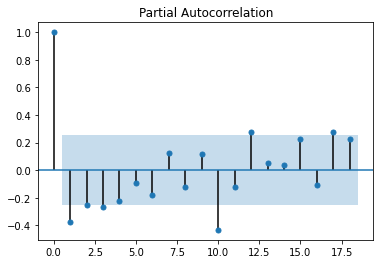

In [ ]:
plot_pacf(log(s).diff().dropna())

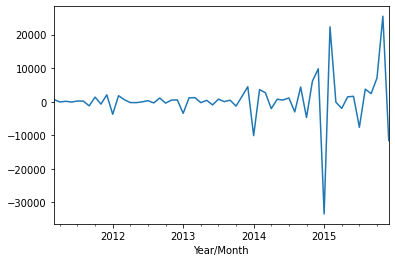

In [ ]:
df.diff().dropna().diff().dropna()['BEV sales'].plot()

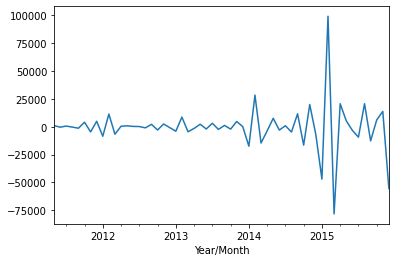

In [ ]:
s.diff().dropna().diff().dropna().diff().dropna().diff().dropna().plot()

In [ ]:
adfuller(log(s).diff().dropna())[1]

0.001082148484561462

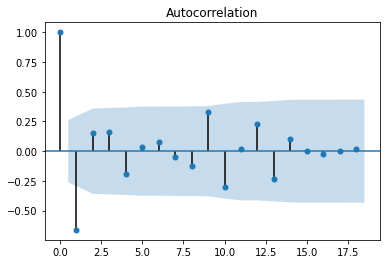

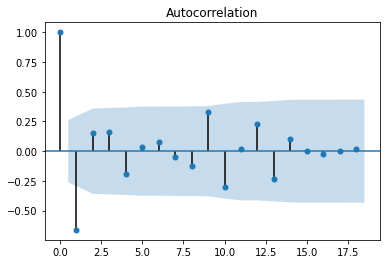

In [ ]:
plot_acf(s.diff().dropna().diff().dropna().diff().dropna().diff().dropna())

In [ ]:
  data.describe()

,Power_consumption,Appliances,Lights
count,308.000000,308.000000,308.000000
mean,570.138707,1417.116883,71.012987
std,45.568249,435.893989,51.527101
min,476.000000,540.000000,0.000000
25%,533.341125,1105.750000,31.000000
50%,561.434125,1343.500000,60.500000
75%,605.993312,1642.000000,95.000000
max,665.000000,2735.000000,258.000000


In [ ]:
missing_dates(data)

2.5974025974025974

In [ ]:
round(missing_dates(data), 2)

2.6

In [ ]:
pipeline(data)

Ingesting Data....
Total datapoints: 709
Checking for missing Dates....
2.54% of dates are missing from dataset!
Imputing Data....
Imputation Done. New Dataframe formed...
Checking Rollup...
Rollup done. Total datapoints after Rollup: 104
Checking Stationarity of data...
Power data is stationary
Test RMSE: 2419.479


,Date,Power
0,2019-01-07,34495.445778
1,2019-01-14,34900.074948
2,2019-01-21,35930.897598
3,2019-01-28,37285.911182
4,2019-02-04,38697.992066
5,2019-02-11,39962.172751
6,2019-02-18,40946.473935
7,2019-02-25,41590.899140
8,2019-03-04,41896.826678
9,2019-03-11,41910.836429


In [ ]:
pd.date_range(datetime.strptime(forecast_start_date, '%m-%d-%Y'),datetime.strptime(Forecast_end_date, '%m-%d-%Y')-timedelta(days=1),freq='7D')

Checking Stationarity of data...
Power_imputed data is stationary


In [ ]:
adfuller(df['Power_imputed'])

(-6.682491895665318,
 4.30706962716056e-09,
 11,
 92,
 {'1%': -3.503514579651927,
  '10%': -2.583823615311909,
  '5%': -2.893507960466837},
 1618.9743760183972)

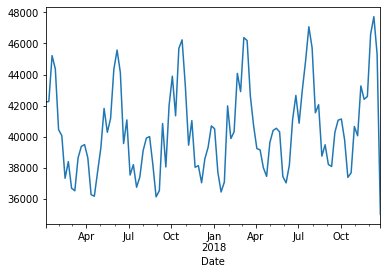

In [ ]:
df['Power_imputed'].plot()

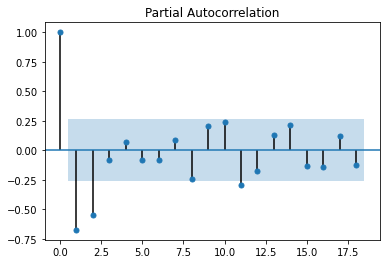

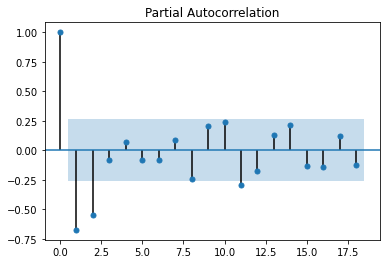

In [ ]:
plot_pacf(s.diff().dropna().diff().dropna().diff().dropna().diff().dropna())

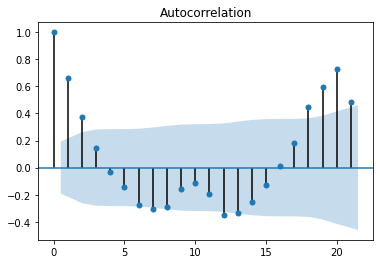

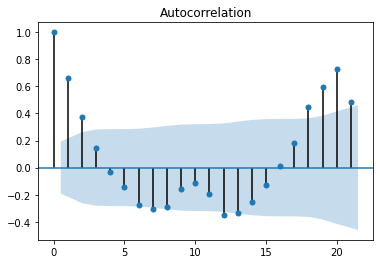

In [ ]:
plot_acf(df['Power_imputed'])

In [ ]:
df.describe()

,Power,Power_imputed
count,104.000000,104.000000
mean,39429.531119,40472.197719
std,4046.927959,2906.450327
min,21864.435834,35010.717356
25%,37424.487873,38166.479608
50%,39415.420257,40168.244034
75%,41395.678043,42235.271875
max,47722.094421,47722.094421


In [ ]:
acf(df['Power_imputed'].values)

array([ 1.        ,  0.65867007,  0.37455115,  0.14587633, -0.03223106,
       -0.14281382, -0.2735724 , -0.30317828, -0.28934542, -0.1580004 ,
       -0.1166267 , -0.19295027, -0.34846449, -0.33615372, -0.25284542,
       -0.13003643,  0.00950086,  0.18091751,  0.44420556,  0.59301025,
        0.72622708,  0.48665575,  0.21175186,  0.06232125, -0.07669899,
       -0.14124505, -0.26335035, -0.28471506, -0.19923842, -0.11966179,
       -0.12026272, -0.20250823, -0.30765387, -0.28905221, -0.19193047,
       -0.09786214,  0.04055376,  0.16489055,  0.38465281,  0.52480997,
        0.47916971])

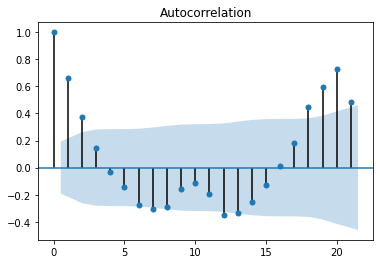

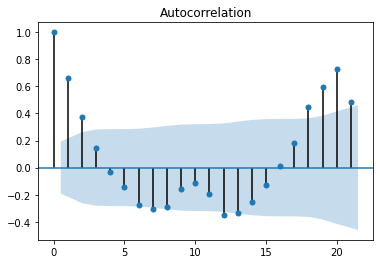

In [ ]:
plot_acf(df['Power_imputed'])

In [ ]:
pacf(df['Power_imputed'].values)

array([ 1.00000000e+00,  6.65064926e-01, -1.08332966e-01, -1.07489924e-01,
       -1.09937430e-01, -6.97635829e-02, -2.08525336e-01, -2.60390314e-02,
       -6.41157862e-02,  1.36961753e-01, -1.64681123e-01, -2.84305934e-01,
       -4.42331571e-01, -7.23870180e-03, -7.35425058e-02,  8.07759119e-02,
        1.89784704e-02,  2.41059712e-01,  3.87284155e-01,  3.15975291e-01,
        7.47855485e-01,  2.15234110e-01,  1.13703369e-01, -4.03872018e-02,
       -4.21642891e-01, -7.10326711e-01, -3.25489966e+00,  1.34422650e+00,
        9.85822812e-01,  2.13177645e+01, -1.04273802e+00, -6.77317746e-01,
       -4.37647055e-01, -3.66855821e-01, -3.64884875e-01, -4.05767829e-01,
       -2.20074284e-01, -3.36498290e-01,  1.39030672e-01,  1.11031569e+00,
       -3.62614551e+00])

In [ ]:
6.65064926e-01 -  1.00000000e+00

-0.334935074

In [ ]:
-1.08332966e-01 - 6.65064926e-01

-0.773397892

In [ ]:
a = pacf(df['Power_imputed'].values, nlags = 10)

In [ ]:
[a[i +1] - a[i] for i in range(len(a) - 1)]

[-0.3349350740682816,
 -0.7733978918866096,
 0.0008430421599230215,
 -0.002447506161818963,
 0.04017384702535477,
 -0.13876175318870237,
 0.18248630472663993,
 -0.038076754808622916,
 0.20107753955984775,
 -0.3016428768549969]

In [ ]:
b = [a[i +1] - a[i] for i in range(len(a) - 1)]
b.index(min(b))

1

In [ ]:
model = ARIMA(df['Power_imputed'], order=(1,1,0))
mf = model.fit()
mf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Power_imputed   No. Observations:                  103
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -944.894
Method:                       css-mle   S.D. of innovations           2332.708
Date:                Thu, 23 Sep 2021   AIC                           1895.787
Time:                        07:05:39   BIC                           1903.691
Sample:                    01-10-2017   HQIC                          1898.989
                         - 12-25-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -70.0378    233.347     -0.300      0.765    -527.390     387.314
ar.L1.D.Power_imputed     0.0141      0.109      0.130      0.897      -0.199       0.227
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           70.9108           +0.0000j           70.9108            0.0000
-----------------------------------------------------------------------------
"""

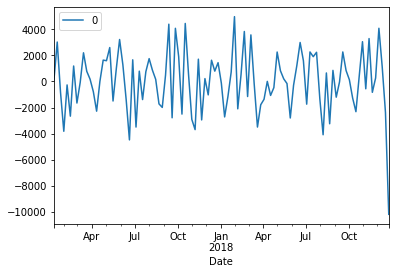

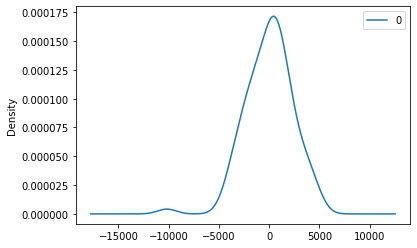

In [ ]:
residuals = pd.DataFrame(mf.resid)
residuals.plot()
residuals.plot(kind='kde')

In [ ]:
residuals.describe()

,0
count,103.000000
mean,-1.398216
std,2344.114216
min,-10179.111890
25%,-1391.604080
50%,157.767357
75%,1583.628526
max,4960.166294


In [ ]:
df['Power_imputed'].values

array([42224.611666 , 42267.2525   , 45214.498857 , 44358.566106 ,
       40457.890752 , 40064.089619 , 37327.940832 , 38399.562084 ,
       36689.434166 , 36524.561666 , 38644.5475   , 39376.7533325,
       39491.822499 , 38637.870833 , 36277.074166 , 36175.776667 ,
       37736.280454 , 39275.160334 , 41820.393492 , 40286.461957 ,
       41174.054742 , 44326.582891 , 45572.433146 , 44129.1079725,
       39560.756081 , 41081.378512 , 37537.059772 , 38203.698356 ,
       36752.685475 , 37409.427034 , 39093.59025  , 39908.767142 ,
       40008.9801845, 38220.065659 , 36134.458583 , 36530.161433 ,
       40848.783111 , 38054.672964 , 42013.111977 , 43894.352171 ,
       41347.660595 , 45681.606025 , 46228.702195 , 43257.359287 ,
       39454.087182 , 41034.214966 , 38037.548781 , 38140.745872 ,
       37041.017715 , 38579.105795 , 39318.600088 , 40694.916456 ,
       40511.5700585, 37720.105085 , 36445.984035 , 37082.819714 ,
       41982.9166835, 39883.06642  , 40314.5020305, 44074.4007

predicted=39837.401903, expected=40310.952482
predicted=39683.177567, expected=37436.949308
predicted=37733.243513, expected=37031.476926
predicted=37655.259232, expected=38175.057520
predicted=38687.507972, expected=41103.351684
predicted=40812.737321, expected=42656.930676
predicted=41797.566108, expected=40866.853248
predicted=40412.979093, expected=43028.945461
predicted=41798.459258, expected=44885.154951
predicted=43177.191815, expected=47072.798827
predicted=44664.453970, expected=45713.608106
predicted=43224.314351, expected=41539.730386
predicted=39610.345229, expected=42058.976651
predicted=40217.605295, expected=38753.446117
predicted=37652.825564, expected=39481.958725
predicted=38572.482642, expected=38215.607334
predicted=37790.497237, expected=38087.631251
predicted=37963.655120, expected=40272.398449
predicted=39897.541835, expected=41065.656953
predicted=40566.097097, expected=41138.578147
predicted=40614.515155, expected=39793.985090
predicted=39570.592125, expected=3

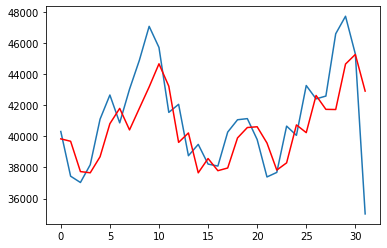

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
X = df['Power_imputed'].values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
forecast_baseline(df, 'Power_imputed', 2, 0, 1)

Test RMSE: 2419.479


[34495.44577814262,
 34900.074947559355,
 35930.89759803598,
 37285.911181959,
 38697.992066001985,
 39962.172750888065,
 40946.47393489326,
 41590.89913972499,
 41896.826678050005,
 41910.83642931434]